# DataJoint U24 - Workflow Array Electrophysiology

## Setup

First, let's change directories to find the `dj_local_conf` file.

In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='workflow-array-ephys', ("Please move to the "
                                                               + "workflow directory")
# We'll be working with long tables, so we'll make visualization easier with a limit
import datajoint as dj; dj.config['display.limit']=10

Next, we populate the python namespace with the required schemas

In [2]:
from workflow_array_ephys.pipeline import session, ephys, trial, event

Connecting cbroz@tutorial-db.datajoint.io:3306


## Trial and Event schemas

Tables in the `trial` and `event` schemas specify the structure of your experiment, including block, trial and event timing. 
- Session has a 1-to-1 mapping with a behavior recording
- A block is a continuous phase of an experiment that contains repeated instances of a condition, or trials. 
- Events may occur within or outside of conditions, either instantaneous or continuous.

The diagram below shows (a) the levels of hierarchy and (b) how the bounds may not completely overlap. A block may not fully capure trials and events may occur outside both blocks/trials.

```
|----------------------------------------------------------------------------|
|-------------------------------- Session ---------------------------------|__
|-------------------------- BehaviorRecording ---------------------------|____
|----- Block 1 -----|______|----- Block 2 -----|______|----- Block 3 -----|___
| trial 1 || trial 2 |____| trial 3 || trial 4 |____| trial 5 |____| trial 6 |
|_|e1|_|e2||e3|_|e4|__|e5|__|e6||e7||e8||e9||e10||e11|____|e12||e13|_________|
|----------------------------------------------------------------------------|
```

Let's load some example data. The `ingest.py` script has a series of loaders to help.

In [4]:
from workflow_array_ephys.ingest import ingest_subjects, ingest_sessions,\
                                        ingest_events, ingest_alignment

In [4]:
ingest_subjects(); ingest_sessions(); ingest_events()


---- Inserting 0 entry(s) into subject ----

---- Insert 0 entry(s) into session.Session ----

---- Insert 0 entry(s) into probe.Probe ----

---- Insert 0 entry(s) into ephys.ProbeInsertion ----

---- Insert 0 entry(s) into session.Session ----

---- Successfully completed workflow_array_ephys/ingest.py ----

---- Inserting 1 entry(s) into behavior_recording ----

---- Inserting 2 entry(s) into behavior_recording__file ----

---- Inserting 4 entry(s) into _block ----

---- Inserting 4 entry(s) into _block__attribute ----

---- Inserting 2 entry(s) into #trial_type ----

---- Inserting 100 entry(s) into _trial ----

---- Inserting 100 entry(s) into _trial__attribute ----

---- Inserting 100 entry(s) into _block_trial ----

---- Inserting 3 entry(s) into #event_type ----

---- Inserting 153 entry(s) into _event ----

---- Inserting 153 entry(s) into _trial_event ----


We have 100 total trials, either 'stim' or 'ctrl', with start and stop time

In [5]:
trial.Trial()

subject,session_datetime,trial_id trial number (1-based indexing),trial_type,trial_start_time (second) relative to recording start,trial_stop_time (second) relative to recording start
subject6,2021-01-15 11:16:38,1,stim,0.123,17.123
subject6,2021-01-15 11:16:38,2,ctrl,17.54,34.54
subject6,2021-01-15 11:16:38,3,ctrl,34.81,51.81
subject6,2021-01-15 11:16:38,4,ctrl,52.202,69.202
subject6,2021-01-15 11:16:38,5,stim,69.611,86.611
subject6,2021-01-15 11:16:38,6,stim,87.03,104.03
subject6,2021-01-15 11:16:38,7,ctrl,104.165,121.165
subject6,2021-01-15 11:16:38,8,ctrl,121.502,138.502
subject6,2021-01-15 11:16:38,9,ctrl,138.612,155.612
subject6,2021-01-15 11:16:38,10,stim,155.741,172.741


Each trial is paired with one or more events that take place during the trial window.

In [6]:
trial.TrialEvent() & 'trial_id<5'

subject,session_datetime,trial_id trial number (1-based indexing),event_type,event_start_time (second) relative to recording start
subject6,2021-01-15 11:16:38,1,center,10.58
subject6,2021-01-15 11:16:38,2,center,21.647
subject6,2021-01-15 11:16:38,3,center,37.044
subject6,2021-01-15 11:16:38,4,center,55.259
subject6,2021-01-15 11:16:38,1,left,4.498
subject6,2021-01-15 11:16:38,3,left,41.892
subject6,2021-01-15 11:16:38,2,right,23.9


Finally, the `AlignmentEvent` describes the event of interest and the window we'd like to see around it.

In [7]:
ingest_alignment()


---- Inserting 3 entry(s) into alignment_event ----


In [8]:
event.AlignmentEvent()

alignment_name,alignment_description,alignment_event_type,alignment_time_shift (s) WRT alignment_event_type,start_event_type,start_time_shift (s) WRT start_event_type,end_event_type,end_time_shift (s) WRT end_event_type
center_button,,center,0.0,center,-3.0,center,3.0
left_button,,left,0.0,left,-3.0,left,3.0
right_button,,right,0.0,right,-3.0,right,3.0


## Event-aligned trialized unit spike times

First, we'll check that the data is still properly inserted from the previous notebooks.

In [10]:
ephys.CuratedClustering()

subject,session_datetime,insertion_number,paramset_idx,curation_id
subject6,2021-01-15 11:16:38,0,0,1


For this example, we'll be looking at `subject6`.

In [11]:
clustering_key = (ephys.CuratedClustering 
                  & {'subject': 'subject6', 'session_datetime': '2021-01-15 11:16:38',
                     'insertion_number': 0}
                 ).fetch1('KEY')

In [13]:
trial.Trial & clustering_key

subject,session_datetime,trial_id trial number (1-based indexing),trial_type,trial_start_time (second) relative to recording start,trial_stop_time (second) relative to recording start
subject6,2021-01-15 11:16:38,1,stim,0.123,17.123
subject6,2021-01-15 11:16:38,2,ctrl,17.54,34.54
subject6,2021-01-15 11:16:38,3,ctrl,34.81,51.81
subject6,2021-01-15 11:16:38,4,ctrl,52.202,69.202
subject6,2021-01-15 11:16:38,5,stim,69.611,86.611
subject6,2021-01-15 11:16:38,6,stim,87.03,104.03
subject6,2021-01-15 11:16:38,7,ctrl,104.165,121.165
subject6,2021-01-15 11:16:38,8,ctrl,121.502,138.502
subject6,2021-01-15 11:16:38,9,ctrl,138.612,155.612
subject6,2021-01-15 11:16:38,10,stim,155.741,172.741


And we can narrow our focus on `ctrl` trials.

In [14]:
ctrl_trials = trial.Trial & clustering_key & 'trial_type = "ctrl"'

The `analysis` schema provides example tables to perform event-aligned spike-times analysis.

In [15]:
from workflow_array_ephys import analysis

+ ***SpikesAlignmentCondition*** - a manual table to specify the inputs and condition for the analysis
+ ***SpikesAlignment*** - a computed table to extract event-aligned spikes and compute unit PSTH

Let's start by creating several analyses configuration - i.e. inserting into ***SpikesAlignmentCondition*** for the `center` event, called `center_button` in the `AlignmentEvent` table.

In [16]:
event.AlignmentEvent()

alignment_name,alignment_description,alignment_event_type,alignment_time_shift (s) WRT alignment_event_type,start_event_type,start_time_shift (s) WRT start_event_type,end_event_type,end_time_shift (s) WRT end_event_type
center_button,,center,0.0,center,-3.0,center,3.0
left_button,,left,0.0,left,-3.0,left,3.0
right_button,,right,0.0,right,-3.0,right,3.0


In [18]:
alignment_key = (event.AlignmentEvent & 'alignment_name = "center_button"'
                ).fetch1('KEY')
alignment_condition = {**clustering_key, **alignment_key, 
                       'trial_condition': 'ctrl_center_button'}
analysis.SpikesAlignmentCondition.insert1(alignment_condition, skip_duplicates=True)

In [19]:
analysis.SpikesAlignmentCondition.Trial.insert(
    (analysis.SpikesAlignmentCondition * ctrl_trials & alignment_condition).proj(),
    skip_duplicates=True)

In [20]:
analysis.SpikesAlignmentCondition.Trial()

subject,session_datetime,insertion_number,paramset_idx,curation_id,alignment_name,trial_condition user-friendly name of condition,trial_id trial number (1-based indexing)
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,2
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,3
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,4
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,7
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,8
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,9
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,13
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,14
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,15
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,16


With the steps above, we have create a new spike alignment condition for analysis, named `ctrl_center_button`, which specifies:
+ a CuratedClustering of interest for analysis
+ an event of interest to align the spikes to - `center_button`
+ a set of trials of interest to perform the analysis on - `ctrl` trials

Now, let's create another set with:
+ the same CuratedClustering of interest for analysis
+ an event of interest to align the spikes to - `center_button`
+ a set of trials of interest to perform the analysis on - `stim` trials

In [21]:
stim_trials = trial.Trial & clustering_key & 'trial_type = "stim"'
alignment_condition = {**clustering_key, **alignment_key, 'trial_condition': 'stim_center_button'}
analysis.SpikesAlignmentCondition.insert1(alignment_condition, skip_duplicates=True)
analysis.SpikesAlignmentCondition.Trial.insert(
    (analysis.SpikesAlignmentCondition * stim_trials & alignment_condition).proj(),
    skip_duplicates=True)

We can compare conditions in the `SpikesAlignmentCondition` table.

In [22]:
analysis.SpikesAlignmentCondition()

subject,session_datetime,insertion_number,paramset_idx,curation_id,alignment_name,trial_condition user-friendly name of condition,condition_description,bin_size bin-size (in second) used to compute the PSTH
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,,0.04
subject6,2021-01-15 11:16:38,0,0,1,center_button,stim_center_button,,0.04


In [23]:
analysis.SpikesAlignmentCondition.Trial & 'trial_condition = "ctrl_center_button"'

subject,session_datetime,insertion_number,paramset_idx,curation_id,alignment_name,trial_condition user-friendly name of condition,trial_id trial number (1-based indexing)
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,2
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,3
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,4
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,7
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,8
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,9
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,13
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,14
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,15
subject6,2021-01-15 11:16:38,0,0,1,center_button,ctrl_center_button,16


### Computation

Now let's run the computation on these.

In [24]:
analysis.SpikesAlignment.populate(display_progress=True)

SpikesAlignment: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.11s/it]


### Vizualize

We can visualize the results with the `plot_raster` function.

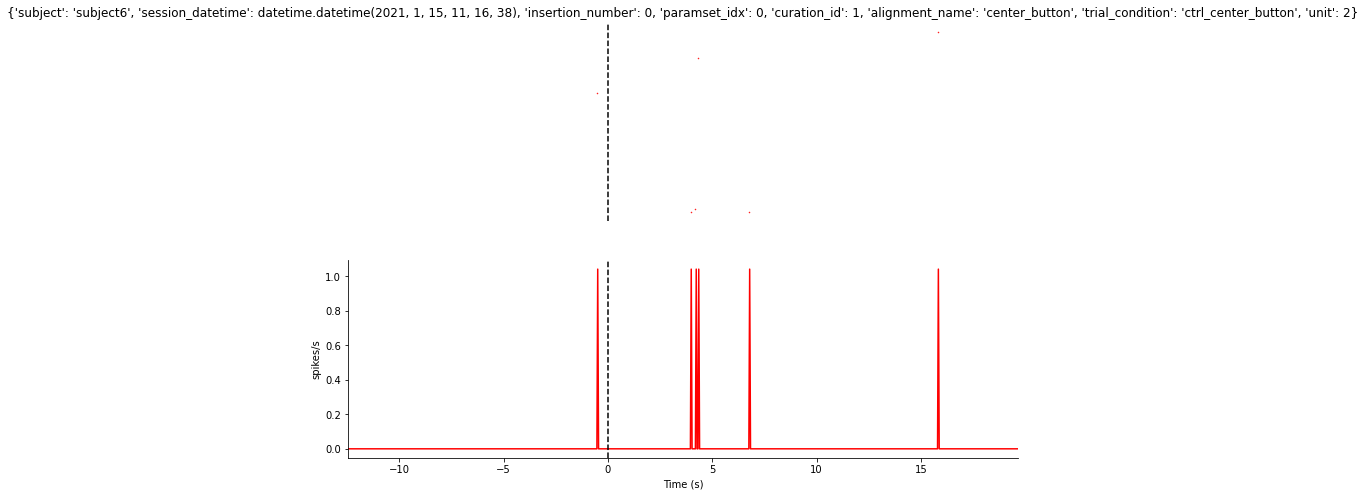

In [25]:
alignment_condition = {**clustering_key, **alignment_key, 'trial_condition': 'ctrl_center_button'}
analysis.SpikesAlignment().plot_raster(alignment_condition, unit=2);

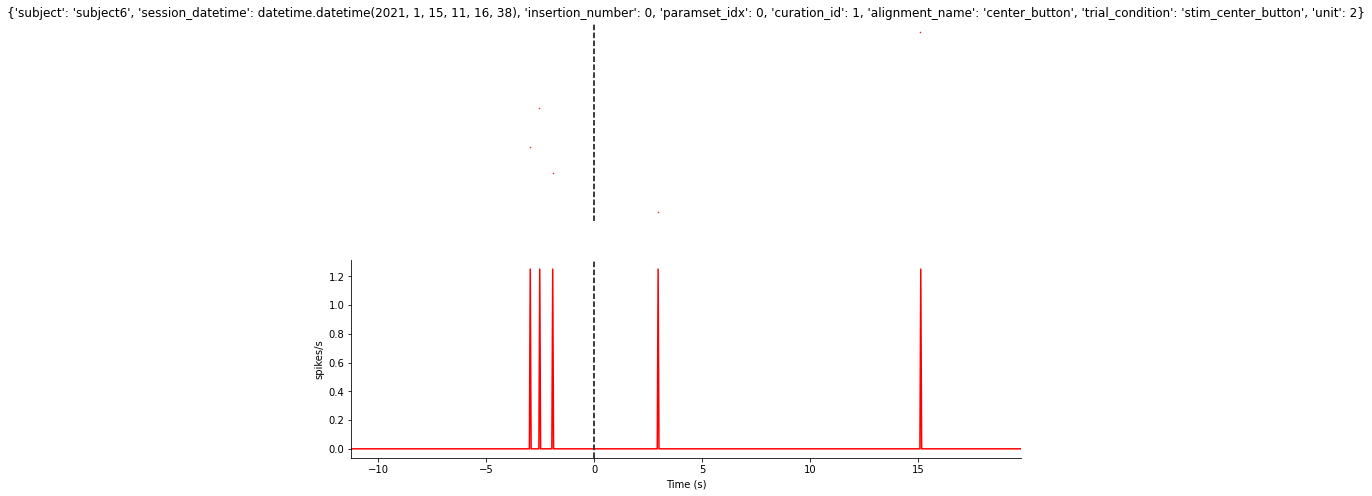

In [26]:
alignment_condition = {**clustering_key, **alignment_key, 'trial_condition': 'stim_center_button'}
analysis.SpikesAlignment().plot_raster(alignment_condition, unit=2);